In [1]:
import pandas as pd
import jsonlines
from tqdm import tqdm
import os

#run it on cpu because i have weak gpu(gt740)...
#feel free to comment this out and see if you get any performance boost
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Using TensorFlow backend.


In [2]:
#Paths
train_db_path='WikiSQL/data/train.db'
train_data_json_path='WikiSQL/data/train.jsonl'
train_table_json_path='WikiSQL/data/train.tables.jsonl'


dev_db_path='WikiSQL/data/dev.db'
dev_data_json_path='WikiSQL/data/dev.jsonl'
dev_table_json_path='WikiSQL/data/dev.tables.jsonl'

test_db_path='WikiSQL/data/test.db'
test_data_json_path='WikiSQL/data/test.jsonl'
test_table_json_path='WikiSQL/data/test.tables.jsonl'

In [3]:
def get_col_tokens(table_json_path):
    tokens=[]
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            for header in obj['header']:
                tokens.append(header)
    return tokens

In [4]:
def get_question_tokens(data_json_path):
    tokens=[]
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            tokens.append(obj['question'])
    return tokens

In [5]:
texts=[]
texts.extend(get_col_tokens(train_table_json_path))
texts.extend(get_col_tokens(dev_table_json_path))
texts.extend(get_col_tokens(test_table_json_path))

18585it [00:00, 38674.20it/s]
2716it [00:00, 33045.37it/s]
5230it [00:00, 28099.53it/s]


In [6]:
texts.extend(get_question_tokens(train_data_json_path))
texts.extend(get_question_tokens(dev_data_json_path))
texts.extend(get_question_tokens(test_data_json_path))

56355it [00:00, 151822.98it/s]
8421it [00:00, 134576.34it/s]
15878it [00:00, 156274.87it/s]


In [7]:
tokenizer=Tokenizer(char_level=True,lower=True)
tokenizer.fit_on_texts(texts)

In [8]:
max_token_index=len(tokenizer.index_word.keys())+1
max_token_index

1246

In [9]:
random=tokenizer.index_word.values()
len(random)

1245

In [10]:
def text2seq(text):
    return np.ravel([tokenizer.texts_to_sequences([text])])

In [11]:
max_len=0
for text in texts:
    if len(text2seq(text))>max_len:
        max_len=len(text2seq(text))
max_len

419

In [12]:
def text2seq(text):
    return np.ravel(pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=max_len,padding='post'))

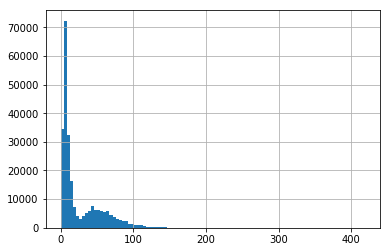

In [13]:
df = pd.Series(texts)
df.str.len().hist(bins=100)
plt.show()

In [14]:
del texts

In [15]:
#make a dict to keep track of all the columns of all the tables
def get_table(table_json_path):
    tables={}
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            tables[obj['id']]={'headers':[],'types':[]}
            tables[obj['id']]['headers']=obj['header']
            tables[obj['id']]['types']=obj['types']
    return tables

In [16]:
train_tables=get_table(train_table_json_path)
dev_tables=get_table(dev_table_json_path)
test_tables=get_table(test_table_json_path)

18585it [00:00, 32001.39it/s]
2716it [00:00, 38625.07it/s]
5230it [00:00, 36170.67it/s]


In [17]:
def get_select_col(dict_obj,tables):
    temp=tables[dict_obj['table_id']]['headers']
    true_selected_column = temp[dict_obj['sql']['sel']]
    false_selected_columns = []
    for selected_column in temp:
        if selected_column != true_selected_column:
            false_selected_columns.append(selected_column)
    return true_selected_column,false_selected_columns
    

In [18]:
def get_dataset(data_json_path,table):
    #read the jsonl file
    Q=[]
    C=[]
    y=[]
    global tokenizer
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            true_column,false_columns=get_select_col(obj,table)
            question=obj['question']
    
            #tokenized representation
            question=text2seq(question)
            true_column=text2seq(true_column)

            for i in range(len(false_columns)):
                false_columns[i]=text2seq(false_columns[i])
            Q.append(question)
            C.append(true_column)
            y.append(1)
            for false_column in false_columns:
                Q.append(question)
                C.append(false_column)
                y.append(0)
    return Q,C,y

In [19]:
Q_train,C_train,y_train=get_dataset(train_data_json_path,train_tables)

56355it [00:13, 4126.43it/s]


In [20]:
Q_dev,C_dev,y_dev=get_dataset(dev_data_json_path,dev_tables)

8421it [00:02, 3924.46it/s]


In [21]:
pos=0
neg=0
for i in range(len(y_train)):
    if y_train[i]==0:
        neg+=1
    else:
        pos+=1
        
print(pos,neg)

56355 304309


In [22]:
idx=[]
for i in range(len(y_train)):
    if y_train[i]==0:
        #coin toss with 50% prob.
        if np.random.randint(2):
            idx.append(i)
idx.sort(reverse=True)
for i in idx:
    Q_train.pop(i)
    C_train.pop(i)
    y_train.pop(i)

In [23]:
len(y_train)

208942

In [24]:
#dimension
d=64

In [25]:
from keras.models import Model
from keras.layers import Input, GRU, Dense ,Flatten , Concatenate,Lambda
from keras.layers.embeddings import Embedding

In [26]:
from keras.constraints import max_norm
from keras import regularizers
from keras.layers import Bidirectional

In [27]:
from keras import backend as K
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [28]:
# Define an input sequence and process it.
question_input = Input(shape=(max_len,),name='Q_input')
column_input = Input(shape=(max_len,),name='C_input')

embedding= Embedding(max_token_index, d, input_length=max_len,name='embedding',mask_zero=True)
# embedding_C= Embedding(max_token_index, d, input_length=max_len,name='embedding_C')
#                      embeddings_constraint=max_norm(2.),
#                      embeddings_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))

Q_embedding= embedding(question_input)
C_embedding= embedding(column_input)



encoder_question = Bidirectional(GRU(d, return_state=True))
_ , Q_state_h1, Q_state_h2 = encoder_question(Q_embedding)

encoder_column = Bidirectional(GRU(d, return_state=True))
_ , C_state_h1, C_state_h2 = encoder_column(C_embedding)


con_Q=Concatenate()([Q_state_h1,Q_state_h2])
con_C=Concatenate()([C_state_h1,C_state_h2])

final = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([con_Q, con_C])
# final=Dense(1,activation='sigmoid')(con)

model = Model([question_input, column_input], final)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
C_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 419, 64)      79744       Q_input[0][0]                    
                                                                 C_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 128), (None, 49536       embedding[0][0]                  
__________

In [29]:
from keras import optimizers

opt = optimizers.Adam()

In [30]:
# Run training
model.compile(optimizer=opt, loss=contrastive_loss,metrics=[accuracy])

In [31]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='select_col_best_model.h5', monitor='val_loss', save_best_only=True)]

In [33]:
from sklearn.utils.class_weight import compute_class_weight
class_weight=compute_class_weight('balanced',np.unique(y_train),y_train)
class_weight

array([0.68466514, 1.85380179])

In [ ]:
history=model.fit([Q_train,C_train], y_train,batch_size=batch_size, epochs=epochs, verbose=1,class_weight=class_weight,
                callbacks=callbacks, validation_data=([Q_dev,C_dev],y_dev))

Train on 208942 samples, validate on 53406 samples
Epoch 1/100
 59520/208942 [=======>......................] - ETA: 32:32 - loss: 0.2010 - accuracy: 0.7239

In [ ]:
Q_test,C_test,y_test=get_dataset(test_data_json_path,test_tables)

In [ ]:
model.load_weights('select_col_best_model.h5')

In [ ]:
model.evaluate([Q_test,C_test],y_test,verbose=1)

In [ ]:
model.evaluate([Q_train,C_train],y_train,verbose=1)

In [ ]:
model.evaluate([Q_dev,C_dev],y_dev,verbose=1)

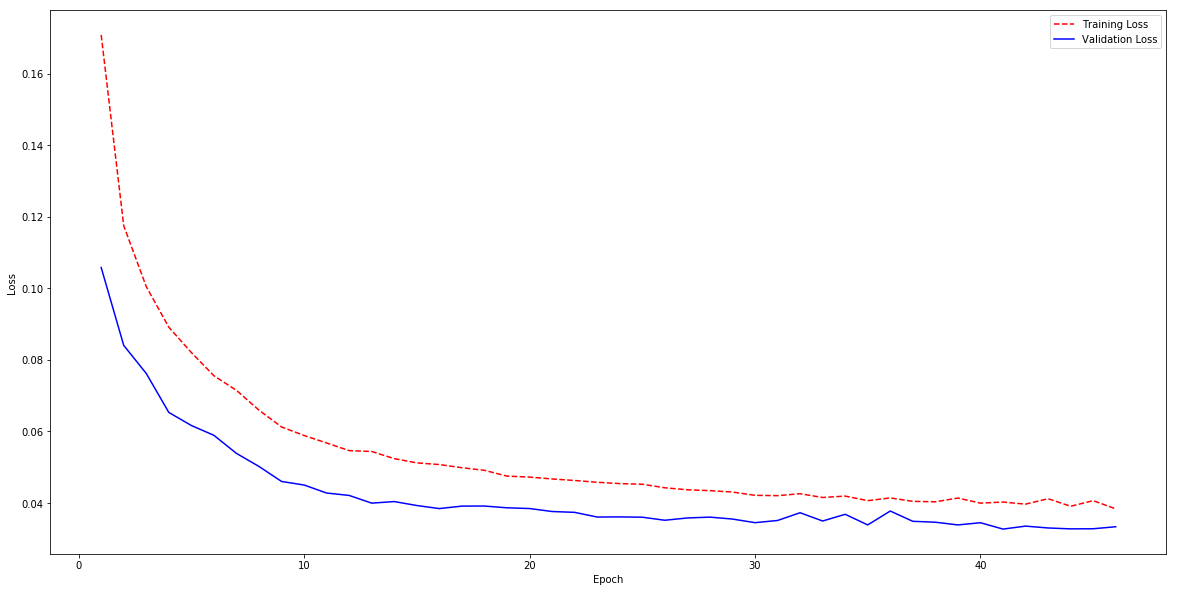

In [44]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

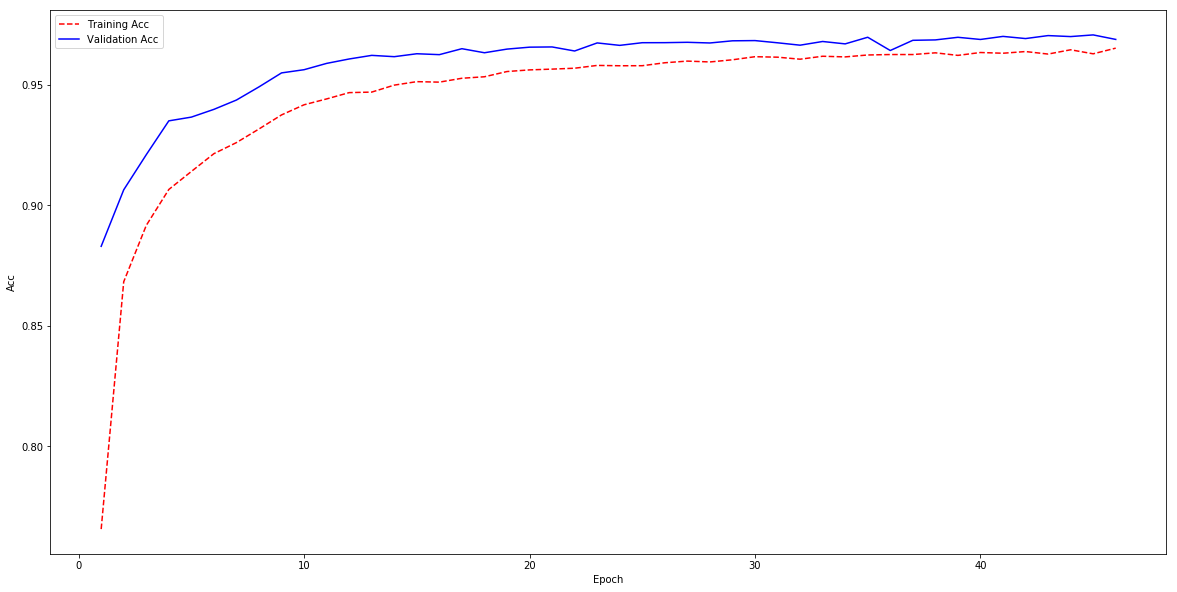

In [45]:
# ,maxlen=max_len,padding='post'# Get training and test loss histories
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.figure(figsize=(20,10))
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show();